In [ ]:
pip install streamz

In [ ]:
pip install --upgrade pip

In [ ]:
pip install aiohttp


In [ ]:
pip install requests

In [ ]:
pip install streamz pandas numpy requests matplotlib pytz statsmodels

In [11]:
# Bitcoin Price Data Ingestion with Streamz
# This notebook demonstrates how to collect real-time Bitcoin price data using the CoinGecko API 
# and ingest it continuously using Streamz

# Install required packages if not already installed
# !pip install streamz requests pandas matplotlib

# Add a header to our requests to be a good API citizen
import requests
headers = {
    'User-Agent': 'Bitcoin Price Research Project - Learning Exercise'
}

import requests
import pandas as pd
import time
import random
from datetime import datetime
import matplotlib.pyplot as plt
from streamz import Stream
from IPython.display import clear_output

# Set up constants
COINGECKO_API_URL = "https://api.coingecko.com/api/v3/simple/price"
QUERY_PARAMS = {
    "ids": "bitcoin",
    "vs_currencies": "usd",
    "include_market_cap": "true",
    "include_24hr_vol": "true",
    "include_24hr_change": "true",
    "include_last_updated_at": "true"
}
POLL_INTERVAL_SECONDS = 30  # Time between API calls - increased to avoid rate limiting

# Create a DataFrame to store the data
columns = ['timestamp', 'price_usd', 'market_cap_usd', '24h_volume_usd', '24h_change_percent']
bitcoin_data = pd.DataFrame(columns=columns)

# Function to fetch Bitcoin data from CoinGecko API
def fetch_bitcoin_data(max_retries=3, initial_backoff=10):
    try:
        for attempt in range(max_retries):
            response = requests.get(COINGECKO_API_URL, params=QUERY_PARAMS, headers=headers)
            if response.status_code == 200:
                data = response.json()
                bitcoin_info = data['bitcoin']
                
                current_time = datetime.now()
                
                return {
                    'timestamp': current_time,
                    'price_usd': bitcoin_info['usd'],
                    'market_cap_usd': bitcoin_info['usd_market_cap'],
                    '24h_volume_usd': bitcoin_info['usd_24h_vol'],
                    '24h_change_percent': bitcoin_info['usd_24h_change']
                }
            elif response.status_code == 429:
                # Rate limited - implement exponential backoff
                backoff_time = initial_backoff * (2 ** attempt)
                print(f"Rate limited. Backing off for {backoff_time} seconds before retry...")
                time.sleep(backoff_time)
            else:
                print(f"API request failed with status code: {response.status_code}")
                return None
        
        print("Max retries reached. Could not get data.")
        return None
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

# Function to process and store incoming data
def process_data(data):
    global bitcoin_data
    if data:
        # Append new data to the DataFrame
        bitcoin_data = pd.concat([bitcoin_data, pd.DataFrame([data])], ignore_index=True)
        
        # Display recent data and plot
        clear_output(wait=True)
        print(f"Last updated: {data['timestamp']}")
        print(f"Current Bitcoin price: ${data['price_usd']:,.2f}")
        print(f"24-hour change: {data['24h_change_percent']:.2f}%")
        print(f"Total data points collected: {len(bitcoin_data)}")
        
        # Plot the price data
        plt.figure(figsize=(12, 6))
        plt.plot(bitcoin_data['timestamp'], bitcoin_data['price_usd'], label='BTC/USD')
        plt.title('Bitcoin Price (USD)')
        plt.xlabel('Time')
        plt.ylabel('Price (USD)')
        plt.grid(True)
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Set up Streamz pipeline
source = Stream()
source.map(lambda x: x).sink(process_data)

# Function to run data collection at regular intervals
def start_data_collection(duration_seconds=300):  # Default to 5 minutes to get more data points
    start_time = time.time()
    count = 0
    
    print(f"Starting Bitcoin price data collection for {duration_seconds} seconds...")
    print(f"Data will be collected approximately every {POLL_INTERVAL_SECONDS} seconds to respect API rate limits")
    
    while time.time() - start_time < duration_seconds:
        try:
            bitcoin_info = fetch_bitcoin_data()
            if bitcoin_info:
                source.emit(bitcoin_info)
                count += 1
            
            # Sleep with a small random variance to avoid synchronized requests
            sleep_time = POLL_INTERVAL_SECONDS + (POLL_INTERVAL_SECONDS * 0.1 * (2 * (0.5 - random.random())))
            time.sleep(sleep_time)
        except KeyboardInterrupt:
            print("\nData collection interrupted by user.")
            break
    
    print(f"Data collection complete. Collected {count} data points.")
    return bitcoin_data

# Run the data collection for 60 seconds (you can adjust this value)
# To start the data collection, run the following line:
# collected_data = start_data_collection(60)

# To save the collected data to a CSV file, you can run:
# bitcoin_data.to_csv('bitcoin_price_data.csv', index=False)



Last updated: 2025-04-29 23:31:25.241737
Current Bitcoin price: $94,693.00
24-hour change: 0.03%
Total data points collected: 4


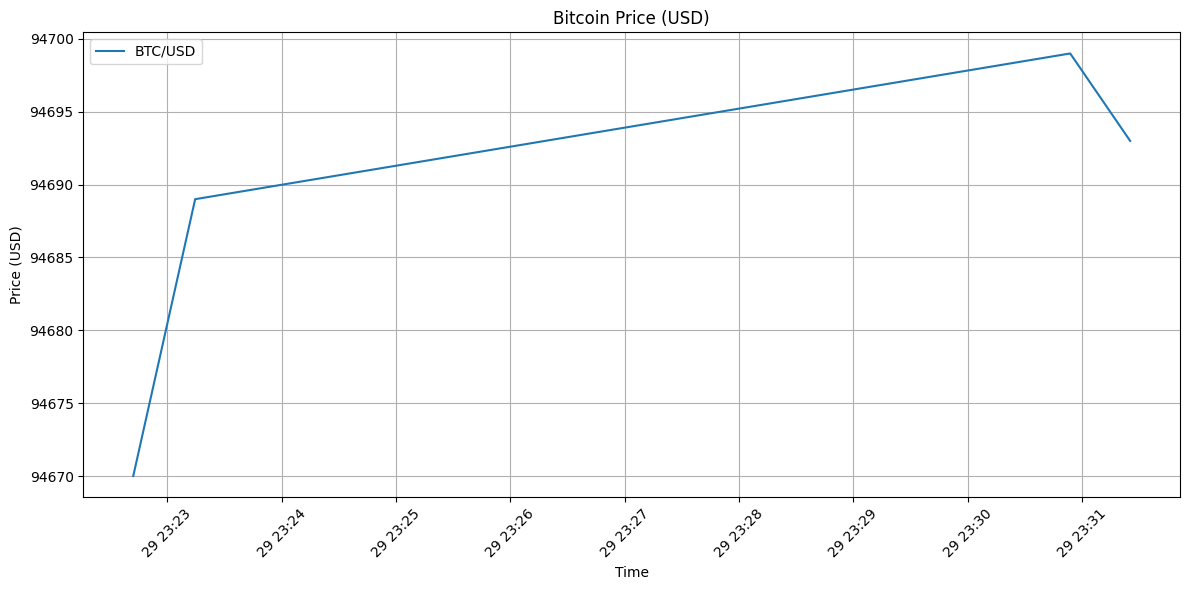

Data collection complete. Collected 2 data points.


In [13]:
collected_data = start_data_collection(60)

In [ ]:
# An alternative implementation using free alternative API (CryptoCompare)
def setup_alternative_api():
    global COINGECKO_API_URL, QUERY_PARAMS
    
    print("Switching to CryptoCompare API as an alternative...")
    
    # Update API configuration
    CRYPTOCOMPARE_API_URL = "https://min-api.cryptocompare.com/data/price"
    CRYPTOCOMPARE_PARAMS = {
        "fsym": "BTC",
        "tsyms": "USD",
        "extraParams": "BitcoinDataCollector"
    }
    
    # Define a new fetch function for CryptoCompare
    def fetch_cryptocompare_data(max_retries=3, initial_backoff=5):
        try:
            for attempt in range(max_retries):
                response = requests.get(CRYPTOCOMPARE_API_URL, params=CRYPTOCOMPARE_PARAMS, headers=headers)
                if response.status_code == 200:
                    data = response.json()
                    
                    # Get more data for additional metrics
                    detail_url = "https://min-api.cryptocompare.com/data/pricemultifull"
                    detail_params = {
                        "fsyms": "BTC",
                        "tsyms": "USD",
                        "extraParams": "BitcoinDataCollector"
                    }
                    detail_response = requests.get(detail_url, params=detail_params, headers=headers)
                    
                    if detail_response.status_code == 200:
                        detail_data = detail_response.json()
                        market_data = detail_data.get('RAW', {}).get('BTC', {}).get('USD', {})
                        
                        current_time = datetime.now()
                        
                        return {
                            'timestamp': current_time,
                            'price_usd': data['USD'],
                            'market_cap_usd': market_data.get('MKTCAP', 0),
                            '24h_volume_usd': market_data.get('VOLUME24HOUR', 0),
                            '24h_change_percent': market_data.get('CHANGEPCT24HOUR', 0)
                        }
                    else:
                        print(f"Detail API request failed: {detail_response.status_code}")
                elif response.status_code == 429:
                    # Rate limited - implement exponential backoff
                    backoff_time = initial_backoff * (2 ** attempt)
                    print(f"Rate limited. Backing off for {backoff_time} seconds before retry...")
                    time.sleep(backoff_time)
                else:
                    print(f"API request failed with status code: {response.status_code}")
                    return None
            
            print("Max retries reached. Could not get data.")
            return None
        except Exception as e:
            print(f"Error fetching data: {e}")
            return None
    
    # Replace the original fetch function
    global fetch_bitcoin_data
    fetch_bitcoin_data = fetch_cryptocompare_data
    
    print("Successfully switched to CryptoCompare API")

# To use the alternative API, run:
# setup_alternative_api()
# collected_data = start_data_collection(300)  # Collect for 5 minutes

Last updated: 2025-04-29 23:37:07.752518
Current Bitcoin price: $94,793.15
24-hour change: 0.11%
Total data points collected: 14


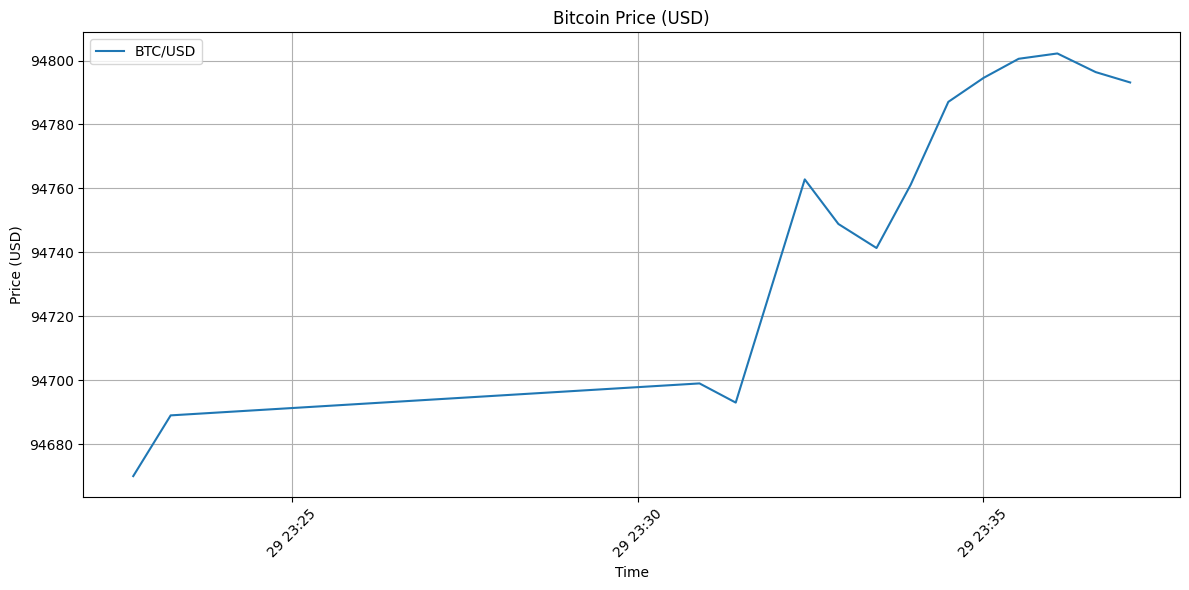

Data collection complete. Collected 10 data points.


In [15]:
setup_alternative_api()
collected_data = start_data_collection(300)  # Collect for 5 minutes